<a href="https://colab.research.google.com/github/Chuck2Win/Variational_Auto_Encoder/blob/master/variational_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy
from matplotlib import pyplot as plt

In [2]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [3]:
# Data 읽어오기
mnist_train_data=torchvision.datasets.MNIST('./',train=True, transform=torchvision.transforms.ToTensor(),download=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
config=Config({'batch_size':64,'hidden_dim':256,'latent_dim':20,'input_size':28*28})

In [5]:
# data loader
train_data_loader=torch.utils.data.DataLoader(mnist_train_data,batch_size=config.batch_size,shuffle=True,drop_last=True)

In [6]:
class encoder(nn.Module):
    def __init__(self,config):
        super(encoder,self).__init__()
        self.config=config
        self.fc=nn.Sequential(nn.Linear(self.config.input_size,self.config.hidden_dim),nn.ReLU())
        self.mu=nn.Linear(self.config.hidden_dim,self.config.latent_dim)
        self.log_var=nn.Linear(self.config.hidden_dim,self.config.latent_dim)
        
    def forward(self,input):
        'input shape : batch_size, C, H, W -> batch_size, input_size + C=1,H,W=28 <- pre processed '
        x=self.fc(input)
        mu=self.mu(x)
        log_var=self.log_var(x)
        return mu,log_var
    
class decoder(nn.Module):
    def __init__(self,config):
        '''
        using sigmoid because of mnist data have 0~1 values <- normalized.
        '''
        super(decoder,self).__init__()
        self.config=config
        self.fc1=nn.Sequential(nn.Linear(self.config.latent_dim,self.config.hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(self.config.hidden_dim,self.config.input_size),nn.Sigmoid()) 

    def forward(self,z):
        x=self.fc1(z)
        output=self.fc2(x)
        return output

In [7]:
class variational_auto_encoder(nn.Module):
    def __init__(self,config):
        super(variational_auto_encoder,self).__init__()
        self.config=config
        self.encoder=encoder(config)
        self.decoder=decoder(config)
        
    def reparametrization(self,mu,log_var):
        '''
        mu, log_var shape : batch_size,latent_dim.
        e ~ N_k(0,I_k) shape : batch_size,latent_dim
        in paper  
        cost(x_i) = -Eq(z|x_i)[log(p(x_i|z))]+KLD(q(z|x_i)|p(z))
        Eq(z|x_i)[log(p(x_i|z))]=1/L(sigma(log(p(x_i|z_i,l)))) l = 1~L "Monte Carlo Expectation estimate
        z_i,l = mu + e_i,l * sigma 
        '''
        sigma=torch.exp(0.5*log_var)
        e=torch.randn_like(sigma,device=sigma.device) # strictly speaking, e shape : batch size, L, latent dim
        z=mu+sigma*e
        return z
        
    def forward(self,input):
        mu,log_var=self.encoder(input)
        self.z=self.reparametrization(mu,log_var)
        output=self.decoder(self.z)
        return output,mu,log_var


In [16]:
def total_loss(decoder_output,input,mu,log_var):
    BCE=F.binary_cross_entropy(decoder_output,input,reduction='sum')
    KL=(-0.5*(log_var+1.-log_var.exp()-mu.pow(2)).sum(dim=-1)).sum()
    return BCE+KL,BCE,KL

In [18]:
def train():
    for x,_ in train_data_loader:
        optimizer.zero_grad()
        x=x.reshape(-1,config.input_size).to(device)
        output,mu,log_var=model(x)
        loss,BCE,KL=total_loss(output,x,mu,log_var)
        loss.backward()
        optimizer.step()
    if epoch%10==0:
        print('epoch', epoch)
        print('total loss : %.2f'%(loss.item()))
        print('cross entropy : %.2f'%(BCE.item()))
        print('kl divergence : %.2f'%(KL.item()))     
        

In [19]:
import time
device='cpu'
epochs=50
model=variational_auto_encoder(config).to(device)
optimizer=torch.optim.Adam(model.parameters())
cost=[]
for epoch in range(epochs):
    now=time.time()
    train()
    

epoch 0
total loss : 8207.12
cross entropy : 6822.63
kl divergence : 1384.50
epoch 10
total loss : 6859.13
cross entropy : 5271.25
kl divergence : 1587.87
epoch 20
total loss : 6870.04
cross entropy : 5223.02
kl divergence : 1647.03
epoch 30
total loss : 7099.57
cross entropy : 5425.16
kl divergence : 1674.41
epoch 40
total loss : 6463.01
cross entropy : 4874.33
kl divergence : 1588.68


In [22]:
mnist_test_data=torchvision.datasets.MNIST('./',train=False, transform=torchvision.transforms.ToTensor(),download=True)
test_data_loader=torch.utils.data.DataLoader(mnist_test_data,batch_size=config.batch_size,drop_last=True)

In [29]:
def test():
    with torch.no_grad():
        total_test_loss=0
        total_test_BCE=0
        total_test_KL=0
        n=0
        for test_data,_ in test_data_loader:
            test_data=test_data.reshape(-1,config.input_size).to(device)
            output,mu,log_var=model.forward(test_data)
            test_loss,test_BCE,test_KL=total_loss(output,test_data,mu,log_var)
            total_test_loss+=test_loss.item()
            total_test_BCE+=test_BCE.item()
            total_test_KL+=test_KL.item()
            n+=1
        print('total_loss', total_test_loss/n)
        print('total_BCE', total_test_BCE/n)
        print('total_KL', total_test_KL/n)
        torchvision.utils.save_image(torch.cat([test_data.reshape(-1,1,28,28),output.reshape(-1,1,28,28)]),'./img_test.png')     
    return mu,log_var

In [30]:
mu,log_var=test()

total_loss 6598.988127879607
total_BCE 5045.281713241186
total_KL 1553.7064193334336


In [32]:
# we hope p(z|x)~p(z) : N(mu,var)~N(0,I) but not exactly same
print(mu.mean())
print((torch.exp(log_var)).mean())

tensor(0.0597)
tensor(0.1679)


In [44]:
def generator(mu,log_var,n):
    e=torch.randn_like(log_var,device=log_var.device)
    z=mu+torch.exp(0.5*log_var)*e
    with torch.no_grad():
        output=model.decoder(z)
    image=output.reshape(-1,28,28)
    for i in range(n):
        plt.imshow(image[i,:,:])
        plt.show()

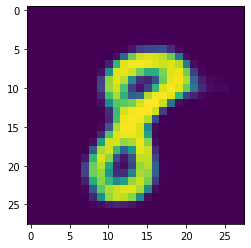

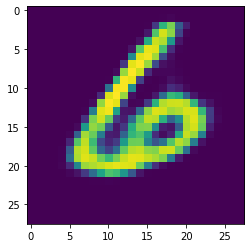

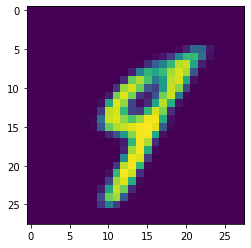

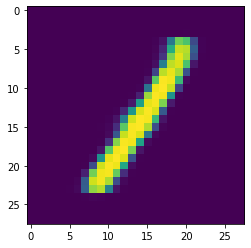

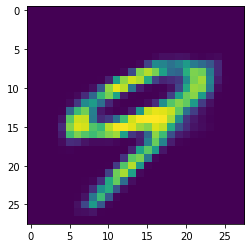

In [45]:
generator(mu,log_var,5)